In [7]:
prefix = '/Users/ddanciu/Downloads/.metagraph_run7/'

fServer = open(f'{prefix}/server.log')
lines = fServer.readlines()

downloaded_sras = set()
build_sras = set()
clean_sras = set()
transfer_sras = set()
ndownloaded_sras = set()
nbuild_sras = set()
nclean_sras = set()
ntransfer_sras = set()
for l in lines:
    if not 'ack' in l:
        continue
    sra_id = l.split('&')[1].split('=')[1]
    if '/ack/download' in l:
        downloaded_sras.add(sra_id)
    elif '/ack/build' in l:
        build_sras.add(sra_id)
    elif '/ack/clean' in l:
        clean_sras.add(sra_id)
    elif '/ack/transfer' in l:
        transfer_sras.add(sra_id)
    elif '/nack/download' in l:
        ndownloaded_sras.add(sra_id)
    elif '/nack/build' in l:
        nbuild_sras.add(sra_id)
    elif '/nack/clean' in l:
        nclean_sras.add(sra_id)
    elif '/nack/transfer' in l:
        ntransfer_sras.add(sra_id)
    
print(f'Downloaded {len(downloaded_sras)}, Built {len(build_sras)}, Cleaned {len(clean_sras)}, Transferred {len(transfer_sras)}')
print(f'Not downloaded {len(ndownloaded_sras)}, Not built {len(nbuild_sras)}, Not cleaned {len(nclean_sras)}, Not transferred {len(ntransfer_sras)}')
    


Downloaded 805, Built 737, Cleaned 690, Transferred 689
Not downloaded 130, Not built 25, Not cleaned 0, Not transferred 0


In [9]:
from collections import defaultdict

download_size = 0
download_size_hist = defaultdict(int)
download_sizes = []
download_time = 0
sra_to_size = {}
ndownload_size_hist = defaultdict(int)

for l in lines:
    if not 'ack/down' in l:
        continue
    sra_id = l.split('&')[1].split('=')[1]
    size = float(l.split('&')[3].split('=')[1])
    
    if '/ack/download' in l:
        download_size_hist[int(size/100) if int(size/100)<200 else 200] += 1
        download_sizes.append(size/1e3)
        sra_to_size[sra_id] = size
        
        if sra_id in transfer_sras:
            download_time += int(l.split('&')[2].split('=')[1])
            download_size = download_size + size
    elif '/nack/download' in l:
        ndownload_size_hist[int(size/100) if int(size/100)<200 else 200] += 1
print(f'Total download size (of finished SRAs): {round(download_size,2)}MB')
print(f'Total download time (of finished SRAs): {download_time}s')
print(f'Download bandwidth (of finished SRAs): {round(download_size/download_time,2)}MB/s/machine')


Total download size (of finished SRAs): 539584.27MB
Total download time (of finished SRAs): 90047s
Download bandwidth (of finished SRAs): 5.99MB/s/machine


In [3]:
time = 0
size_download = 0
size_build = 0
build_size_hist = defaultdict(int)
build_sizes = []
build_size_to_time = {}
nbuild_size_hist = defaultdict(int)
nbuild_sizes = []

for d in lines:
    if not 'ack/build' in d:
        continue
    if '/ack/build' in d:
        sra_id = d.split('&')[1].split('=')[1]
        sz = sra_to_size[sra_id] #float(d.split('&')[4].split('=')[1])
        build_size_hist[int(sz/100) if int(sz/100)<200 else 200] += 1
        build_sizes.append(sz/1e3)
        tm = float(d.split('&')[2].split('=')[1])
        size_build += float(d.split('&')[4].split('=')[1])
        build_size_to_time[sz] = tm
        if sra_id in transfer_sras:
            time = time + tm
            size_download += sz
    elif '/nack/build' in d:
        sz = sra_to_size[sra_id]
        nbuild_size_hist[int(sz/100) if int(sz/100)<200 else 200] += 1
        nbuild_sizes.append(sz/1e3)

print(f'Total build time (of finished SRAs): {time}s')
print(f'Total build size (of finished SRAs): {size_build}MB')
print(f'Build bandwidth is {size_download/time}MB/s')


Total build time (of finished SRAs): 167884.0s
Total build size (of finished SRAs): 575490.4100000001MB
Build bandwidth is 4.064033856710584MB/s


In [4]:
time = 0
clean_size = 0
for d in lines:
    if not 'ack/clean' in d:
        continue
    sra_id = d.split('&')[1].split('=')[1]
    if sra_id in transfer_sras:
        time = time + float(d.split('&')[2].split('=')[1])
        clean_size = clean_size + float(d.split('&')[3].split('=')[1])
        
    
print(f'Total clean time (of finished SRAs): {time}s')
print (f'Clean bandwidth is {download_size} {time} {round(download_size/time,2)}MB/s')
print(f'Compression factor is {download_size/clean_size}')

Total clean time (of finished SRAs): 475027.0s
Clean bandwidth is 682286.2599999995 475027.0 1.44MB/s
Compression factor is 17.926634107481043


In [5]:
import matplotlib.pyplot as plt

plt.bar(list(download_size_hist.keys()), download_size_hist.values(), color='g')
plt.ylabel('count')
plt.xlabel('size (100s of MB)')
plt.title('SRA distribution by size (download successful)')
plt.show()

plt.bar(list(ndownload_size_hist.keys()), ndownload_size_hist.values(), color='g')
plt.ylabel('count')
plt.xlabel('size (100s of MB)')
plt.title('SRA distribution by size (download failed)')
plt.show()

plt.hist(download_sizes, bins=range(0,80))

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

(array([583., 105.,  53.,  20.,  10.,  12.,   7.,  11.,   1.,   3.,   1.,
          2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 <a list of 79 Patch objects>)

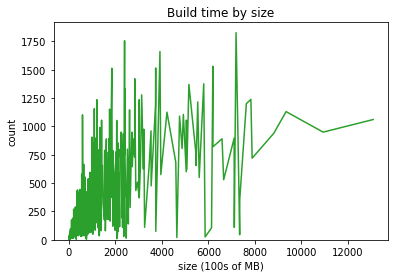

In [6]:
import collections

plt.bar(list(build_size_hist.keys()), build_size_hist.values(), color='g')
plt.ylabel('count')
plt.xlabel('size (100s of MB)')
plt.title('SRA distribution by size (build successful)')
#plt.show()

plt.bar(list(nbuild_size_hist.keys()), nbuild_size_hist.values(), color='g')
plt.ylabel('count')
plt.xlabel('size (100s of MB)')
plt.title('SRA distribution by size (build failed)')
#plt.show()

plt.title('SRA histogram')
plt.hist(build_sizes, bins=[0, 10, 20, 30, 40, 50])
plt.hist(nbuild_sizes, bins=[0, 10, 20, 30, 40, 50])

plt.title('Build time by size')
od = collections.OrderedDict(sorted(build_size_to_time.items()))
plt.plot(list(od.keys()), list(od.values()))

